In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import HGate,RGate, XGate
from qiskit.visualization import plot_histogram
import numpy as np

# Single Qubit Circuits

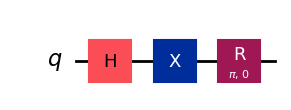

In [3]:
#Method 1
qc = QuantumCircuit(1)

qc.append(HGate(),[0])
qc.append(XGate(),[0])
qc.append(RGate(np.pi, 0),[0])

qc.draw('mpl')

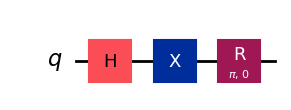

In [4]:
#Method 2
qc_1 = QuantumCircuit(1)

qc_1.h(0)
qc_1.x(0)
qc_1.r(np.pi,0,0)

qc_1.draw('mpl')

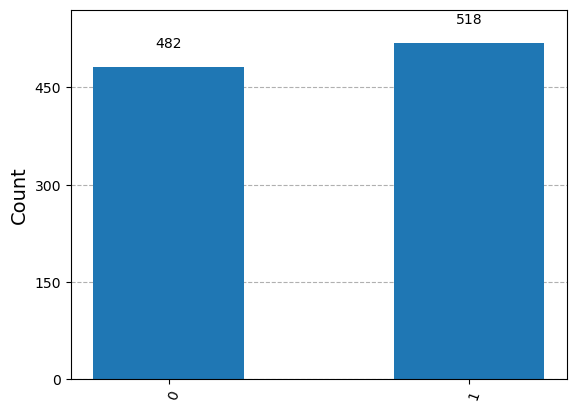

In [12]:
ket = Statevector([1,0])
v = ket.evolve(qc_1)
v.draw('text')

stats = v.sample_counts(1000)
plot_histogram(stats)

# Compose and Decompose Cicuits

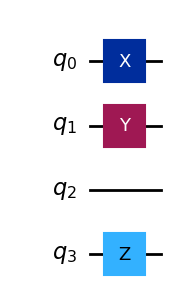

In [14]:
qc_a = QuantumCircuit(4)
qc_a.x(0)

qc_b = QuantumCircuit(2)
qc_b.y(0)
qc_b.z(1)

#appends Y gate to q1 and Z gate to q3 for the circuit qc_a and returns a new circuit qc_ab
qc_ab = qc_a.compose(qc_b, qubits=[1,3])
qc_ab.draw('mpl')

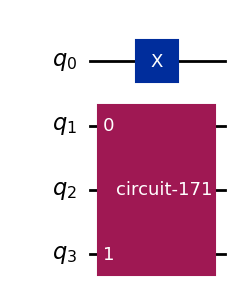

In [15]:
#Returns equivalent circuit as above, but replaces qc_b as an instruction for simplicity
instruction = qc_b.to_instruction()
qc_a.append(instruction, [1,3])

qc_a.draw('mpl')

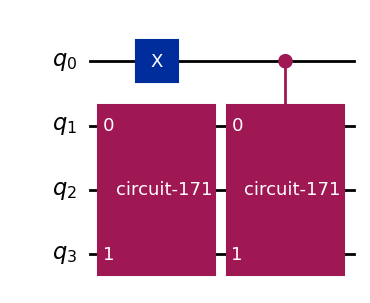

In [16]:
#Introduce gate if circuit is unitary, plus control() adds quantum control
gate = qc_b.to_gate().control()
qc_a.append(gate,[0,1,3])
qc_a.draw('mpl')

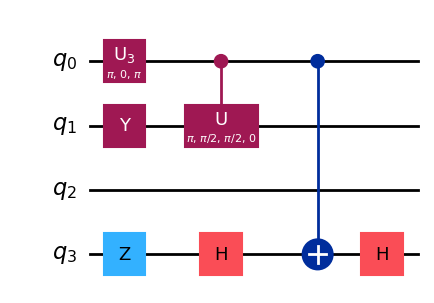

In [17]:
#Keep in mind HXH = Z and HZH = X
qc_a.decompose().draw('mpl')

In [36]:
plus = Statevector.from_label("+")
minus = Statevector.from_label("-")
i_state = Statevector([1 / np.sqrt(2), 1j / np.sqrt(2)])
j_state = Statevector([1 / np.sqrt(2), -1j / np.sqrt(2)])

#4 qubit wf
psi = plus.tensor(i_state).tensor(minus).tensor(j_state)

psi.draw("latex")

<IPython.core.display.Latex object>

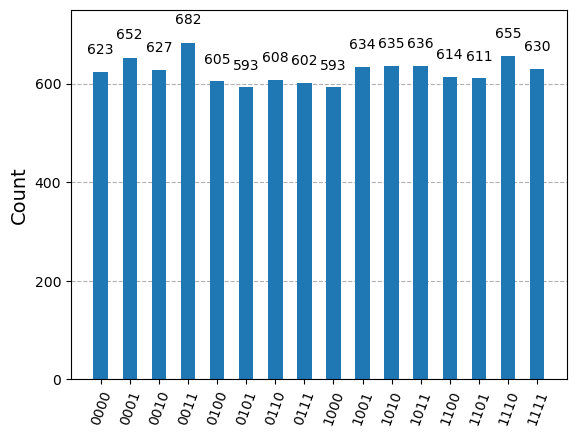

In [39]:
v_a = psi.evolve(qc_a)
v_a.draw('text')

stats_a = v_a.sample_counts(10000)
plot_histogram(stats_a)

# Parametrized Circuits

In [14]:
from qiskit.circuit import Parameter

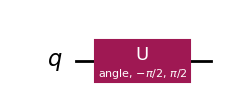

In [16]:
angle = Parameter("angle")  # undefined number
 
# Create and optimize circuit once
qc = QuantumCircuit(1)
qc.rx(angle, 0)
 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
qc = generate_preset_pass_manager(optimization_level=3, basis_gates=['u', 'cx']).run(qc)
 
qc.draw("mpl")

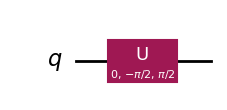

In [22]:
circuits = []

for val in range(100):
    circuits.append(qc.assign_parameters({angle:val}))
    
circuits[0].draw('mpl')

In [23]:
qc.parameters

ParameterView([Parameter(angle)])

# N Local Circuits

Combines single qubit rotation gates with multi qubit entanglement gates
    -> Good for variational algorithms bc they create wide range of quantum states

In [24]:
from qiskit.circuit.library import TwoLocal

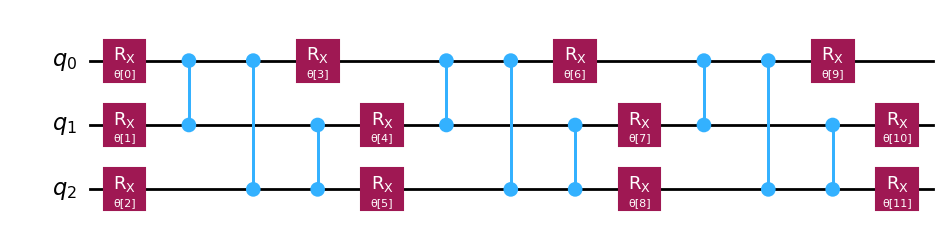

In [28]:
two_local = TwoLocal(3, 'rx', 'cz')
two_local.decompose().draw('mpl')

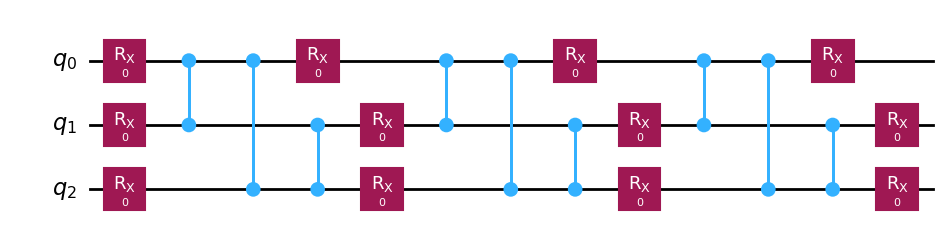

In [29]:
bound_circuit = two_local.assign_parameters({p:0 for p in two_local.parameters})
bound_circuit.decompose().draw('mpl')

# Data Encoding Circuits

Encode data onto quantum states for use of quantum machine learning algs

Amplitude encoding-> stores data in the amplitude, stores up to $2^n$ numbers/state but costly

Basis Encoding-> stores data by preparing basis state

Angle Encoding-> stores data in rotation angle


In [30]:
from qiskit.circuit.library import ZZFeatureMap

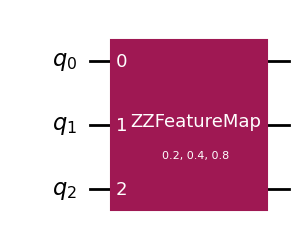

In [32]:
#Angle Encoding
features = [.2,.4,.8]
feature_map = ZZFeatureMap(feature_dimension = len(features))

encoded = feature_map.assign_parameters(features)
encoded.draw('mpl')

# Time Evolution Circuits

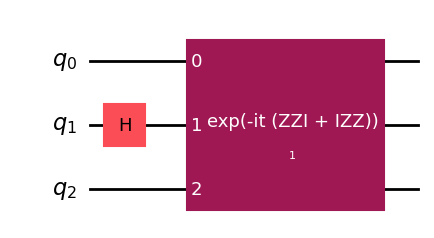

In [35]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
 
 
# Prepare an initial state with a Hamadard on the middle qubit
state = QuantumCircuit(3)
state.h(1)
 
hamiltonian = SparsePauliOp(["ZZI", "IZZ"])
evolution = PauliEvolutionGate(hamiltonian, time=1)
 
# Evolve state by appending the evolution gate
state.compose(evolution, inplace=True)
 
state.draw('mpl')

# Arithmetic Circuits

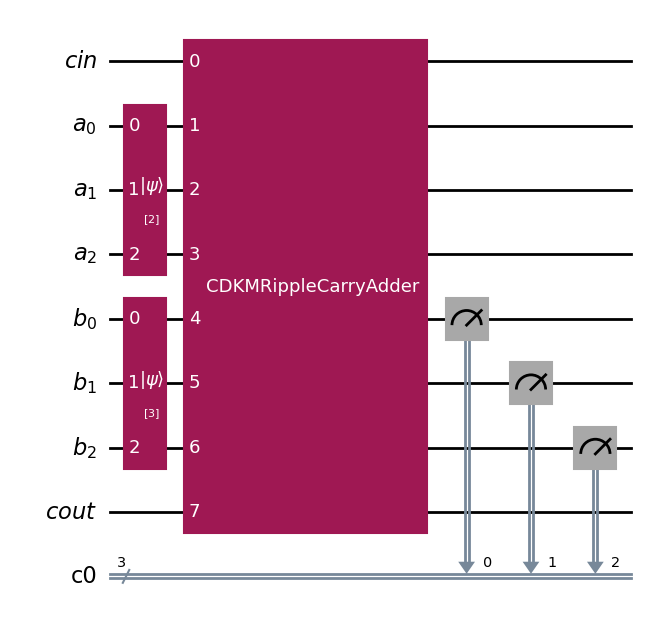

In [36]:
from qiskit.circuit.library import CDKMRippleCarryAdder
adder = CDKMRippleCarryAdder(3)  # Adder of 3-bit numbers
 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
 
# Create the number A=2
reg_a = QuantumRegister(3, 'a')
number_a = QuantumCircuit(reg_a)
number_a.initialize(2) # Number 2; |010>
 
# Create the number B=3
reg_b = QuantumRegister(3, 'b')
number_b = QuantumCircuit(reg_b)
number_b.initialize(3)  # Number 3; |011>
 
# Create a circuit to hold everything, including a classical register for
# the result
reg_result = ClassicalRegister(3)
circuit = QuantumCircuit(*adder.qregs, reg_result)
 
# Compose number initializers with the adder. Adder stores the result to
# register B, so we'll measure those qubits.
circuit = circuit.compose(number_a, qubits=reg_a).compose(number_b, qubits=reg_b).compose(adder)
circuit.measure(reg_b, reg_result)
circuit.draw('mpl')

In [37]:
from qiskit.primitives import Sampler
 
result = Sampler().run(circuit).result()
result.quasi_dists[0]

{5: 1.0}

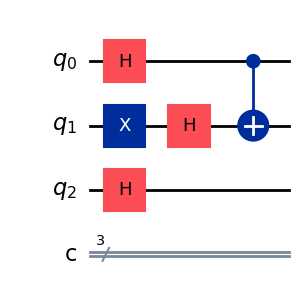

In [63]:
circuit = QuantumCircuit(3,3)
circuit.x(1)
circuit.h(range(3))
circuit.cx(0,1)
circuit.draw('mpl')

In [64]:
circuit.measure(range(3), range(3))
print(circuit)

     ┌───┐          ┌─┐   
q_0: ┤ H ├───────■──┤M├───
     ├───┤┌───┐┌─┴─┐└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ X ├─╫─┤M├
     ├───┤└┬─┬┘└───┘ ║ └╥┘
q_2: ┤ H ├─┤M├───────╫──╫─
     └───┘ └╥┘       ║  ║ 
c: 3/═══════╩════════╩══╩═
            2        0  1 


# Basic Roadmap for Looking at Evolution of A Wavefunction

1) Build QuantumCircuit

2) Build StateVector -> dimension is the number of qubits

In [98]:
qc = QuantumCircuit(3,3)
qc.h(range(3))
qc.measure(0,0)

In [103]:
# Use the Aer simulator
from qiskit_aer import AerSimulator
from qiskit_aer import Aer
from qiskit import transpile

simulator = Aer.get_backend('qasm_simulator')

# Transpile the circuit for the simulator
compiled_circuit = transpile(qc, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots = 1)

# Get the results from the job
result = job.result()

# Get the counts (measurement results)
counts = result.get_counts(qc)
print("Measurement results:", counts)


Measurement results: {'001': 1}
